# OLD BS

In [8]:
import numpy as np
import dask.array as da
from scipy.ndimage import gaussian_filter
from dask.diagnostics import ProgressBar
import nd2

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="ND2File file not closed before garbage collection")

def dog_filter_2d(im, sigma1=0.5, sigma2=4, dtype=np.float32):
    """Apply a difference of Gaussians filter."""
    im1 = gaussian_filter(im.astype(dtype), sigma1)
    im2 = gaussian_filter(im.astype(dtype), sigma2)
    return im1 - im2

def parallel_dog_filter_2d(array, sigma1=0.5, sigma2=4):
    """Apply DoG filtering in parallel using Dask."""
    return da.map_blocks(
        lambda block: dog_filter_2d(block, sigma1, sigma2),
        array,
        dtype=np.float32,
    )

def filter_dask(dask_array, fpv=30, offset_frames=10, N_neurons=10, 
                y_min=150, y_max=450, x_min=450, x_max=800, 
                sig1=0.5, sig2=4, test=False):
    """
    Flip alternate volumes in a Dask array, crop, apply DoG filtering, then reshape.
    """
    total_frames = dask_array.shape[0]

    # ------------------------------------------------------------------------
    # 1) Crop
    # ------------------------------------------------------------------------
    cropped_array = dask_array[:, :, y_min:y_max, x_min:x_max]

    # ------------------------------------------------------------------------
    # 2) Determine frames to keep and flip indices for odd volumes
    # ------------------------------------------------------------------------
    start_frame = offset_frames
    remaining_frames = total_frames - start_frame
    n_complete_volumes = remaining_frames // fpv
    end_frame = start_frame + (n_complete_volumes * fpv)

    if test:
        # In test mode, limit to first 100 volumes
        end_frame = min(start_frame + 2 * fpv, total_frames)

    # Create the index array for all frames we want
    indices = np.arange(start_frame, end_frame)

    # Flip the indices for the odd volumes
    for vol in range((end_frame - start_frame) // fpv):
        if vol % 2 == 1:  # Odd-numbered volume
            vol_start = start_frame + (vol * fpv)
            vol_end = vol_start + fpv
            indices_slice = slice(vol_start - start_frame, vol_end - start_frame)
            indices[indices_slice] = indices[indices_slice][::-1]

    # Apply the flipped indices to get our final time axis
    flipped_array = cropped_array[indices]
    # Optionally, rechunk along the time dimension (use a chunk size that works best for your memory):
    flipped_array = flipped_array.rechunk((128, 1, -1, -1))
    
    # ------------------------------------------------------------------------
    # 3) Apply DoG filter over the entire first dimension
    #    (i.e., time axis across all frames)
    # ------------------------------------------------------------------------
    with ProgressBar():
        filtered_dask_array = parallel_dog_filter_2d(flipped_array, sig1, sig2)

    # ------------------------------------------------------------------------
    # 4) Only now do we reshape/transpose into (volumes, ... ) if needed
    # ------------------------------------------------------------------------
    num_volumes = len(indices) // fpv
    # Reshape to (num_volumes, fpv, channels, Y, X)
    filtered_dask_array = filtered_dask_array.reshape(num_volumes, fpv, *filtered_dask_array.shape[1:])
    
    # Example of transposing to reorder dims. If your final layout is:
    # (volume, channel, width, depth, height), adjust accordingly.
    # Currently: (V, T, C, Y, X)
    filtered_dask_array = filtered_dask_array.transpose(0, 2, 4, 3, 1)  # => (V, C, X, Y, T)

    # ------------------------------------------------------------------------
    # 5) Normalize & scale lazily in [0,255], then cast
    # ------------------------------------------------------------------------
    filtered_dask_array -= filtered_dask_array.min()
    filtered_dask_array /= filtered_dask_array.max()
    filtered_dask_array *= 255
    filtered_dask_array = da.clip(filtered_dask_array, 0, 255).astype(np.int16)

    print(f"Cropped and filtered dask array shape: {filtered_dask_array.shape}")
    return filtered_dask_array


In [9]:
import h5py
import numpy as np
from tqdm import tqdm
from dask.diagnostics import ProgressBar

def write_filtered_volumes_to_hdf5_lazy(filtered_dask_array, output_filename, N_neurons=10):
    """
    Write the filtered Dask array (V, C, X, Y, Z) to an HDF5 file one volume at a time.

    Args:
        filtered_dask_array (dask.array): The processed Dask array with shape (V, C, X, Y, Z).
        output_filename (str): The output HDF5 file path.
        N_neurons (int): Number of neurons for mask and point data initialization.
    """
    # Extract dimensions
    V, C, X, Y, Z = filtered_dask_array.shape

    # Open HDF5 file for writing
    with h5py.File(output_filename, "w") as h5:

        # Create a progress bar over V volumes
        with tqdm(total=V, desc="Writing volumes") as pbar:
            for v_idx in range(V):
                # Compute the slice for this volume => shape (C, X, Y, Z)
                with ProgressBar():
                    volume_data = filtered_dask_array[v_idx].compute()

                # ---- Create the volume dataset ----
                # We name it "<v_idx>/frame" (or any naming convention you prefer)
                # shape: (C, X, Y, Z)
                frame_dset = h5.create_dataset(
                    f"{v_idx}/frame", 
                    data=volume_data,  # already int16 if you did the cast earlier
                    compression="gzip"
                )

                # ---- Create mask dataset ----
                # Example dummy mask of shape (X, Y, Z) for each volume.
                mask_shape = (X, Y, Z)
                mask_data = np.random.randint(0, N_neurons + 1, mask_shape).astype(np.int16)
                mask_dset = h5.create_dataset(
                    f"{v_idx}/mask", 
                    data=mask_data, 
                    compression="gzip"
                )

                pbar.update(1)

        # ---- Optionally, create a point dataset ----
        # Example shape (V, N_neurons+1, 3), storing random 3D coords 
        # within [X, Y, Z] or [C, X, Y], etc. — adjust to suit your data
        point_dset = h5.create_dataset("pointdat", (V, N_neurons + 1, 3), dtype="f4")
        # e.g., random coords in [X, Y, Z]
        point_vals = np.random.random((V, N_neurons + 1, 3)) * np.array([X, Y, Z])[None, None, :]
        point_dset[...] = point_vals.astype(np.float32)
        # set first point to NaN (as in your original example)
        point_dset[:, 0] = np.nan  

        # ---- Add some metadata as attributes ----
        h5.attrs["name"] = "testingtesting"
        h5.attrs["V"] = V
        h5.attrs["C"] = C
        h5.attrs["X"] = X
        h5.attrs["Y"] = Y
        h5.attrs["Z"] = Z
        h5.attrs["N_neurons"] = N_neurons
        h5.attrs['points_data'] = True

    print(f"Data successfully written to {output_filename}")


In [3]:
# Load the ND2 file
import numpy as np
import dask.array as da
from scipy.ndimage import gaussian_filter
from dask.diagnostics import ProgressBar
import nd2

import warnings
import warnings
# Suppress ND2File warnings inside jupyter notebook
warnings.filterwarnings("ignore", category=UserWarning, message="ND2File file not closed before garbage collection")
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
with nd2.ND2File(file_path) as f:
    dask_array = nd2.imread(file_path, dask=True)
    
    # Print basic information about the Dask array
    print(f"Dask Array Shape: {dask_array.shape}")
    print(f"Dask Array Data Type: {dask_array.dtype}")

    # Print general metadata
    # print("Metadata:", f.metadata)
    
    # Print voxel sizes
    print("Voxel Size:", f.voxel_size())
    
    # Print the sizes of the dimensions (e.g., T, C, Y, X)
    print("Dimension Sizes:", f.sizes)
    
    # Access attributes like channel names
    channels = [ch.channel.name for ch in f.metadata.channels]
    print("Channels:", channels)
    

#data = nd2.imread(file_path) #SLOW AND BAD for 30GB file like worm_1nd2003
filtered_dask_array = filter_dask(dask_array, test = True)
output_filename = "./20250115-test-2-filtered-frames.h5"
write_filtered_volumes_to_hdf5_lazy(
    filtered_dask_array=filtered_dask_array,
    output_filename=output_filename,
    N_neurons=84 #from OG targettrack
)

Dask Array Shape: (20000, 2, 512, 1024)
Dask Array Data Type: uint16
Voxel Size: VoxelSize(x=0.325, y=0.325, z=1.0)
Dimension Sizes: {'T': 20000, 'C': 2, 'Y': 512, 'X': 1024}
Channels: ['Mono', 'EM525/50']


NameError: name 'filter_dask' is not defined

In [28]:
import h5py
import numpy as np
from tqdm import tqdm
from dask.diagnostics import ProgressBar

# Load the ND2 file
import warnings
# Suppress ND2File warnings inside jupyter notebook
warnings.filterwarnings("ignore", category=UserWarning, message="ND2File file not closed before garbage collection")
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
with nd2.ND2File(file_path) as f:
    dask_array = nd2.imread(file_path, dask=True)
    
    # Print basic information about the Dask array
    print(f"Dask Array Shape: {dask_array.shape}")
    print(f"Dask Array Data Type: {dask_array.dtype}")

    # Print general metadata
    # print("Metadata:", f.metadata)
    
    # Print voxel sizes
    print("Voxel Size:", f.voxel_size())
    
    # Print the sizes of the dimensions (e.g., T, C, Y, X)
    print("Dimension Sizes:", f.sizes)
    
    # Access attributes like channel names
    channels = [ch.channel.name for ch in f.metadata.channels]
    print("Channels:", channels)
    

# #data = nd2.imread(file_path) #SLOW AND BAD for 30GB file like worm_1nd2003
# filtered_array = filter_dask(dask_array, test = True)

# def write_filtered_frames_to_hdf5_lazy(filtered_dask_array, output_filename, N_neurons=10):
#     """
#     Write the filtered Dask array to an HDF5 file one frame at a time with progress tracking.

#     Args:
#         filtered_dask_array: The processed Dask array (T, C, W, H, D) to write.
#         output_filename: The output HDF5 file path.
#         N_neurons: Number of neurons for mask and point data initialization.
#     """
#     # Extract dimensions
#     T, C, W, H, D = filtered_dask_array.shape

#     # Open HDF5 file for writing
#     with h5py.File(output_filename, "w") as h5:
#         # Initialize datasets and write frame by frame
#         with tqdm(total=T, desc="Writing frames and masks") as pbar:
#             for t in range(T):
#                 # Compute one frame at a time with Dask progress tracking
#                 with ProgressBar():
#                     frame = filtered_dask_array[t].compute()

#                 # Create frame dataset
#                 frame_dset = h5.create_dataset(f"{t}/frame", (C, W, H, D), dtype="i2", compression="gzip")
#                 frame_dset[...] = frame.astype(np.int16)

#                 # Create mask dataset
#                 mask_dset = h5.create_dataset(f"{t}/mask", (W, H, D), dtype="i2", compression="gzip")
#                 mask_dset[...] = np.random.randint(0, N_neurons + 1, (W, H, D)).astype(np.int16)

#                 # Update progress bar
#                 pbar.update(1)

#         # Initialize point data
#         point_dset = h5.create_dataset("pointdat", (T, N_neurons + 1, 3), dtype="f4")
#         point_dset[...] = (np.random.random((T, N_neurons + 1, 3)) * np.array([W, H, D])[None, None, :]).astype(np.float32)
#         point_dset[:, 0] = np.nan  # Set first point to NaN

#         # Add metadata attributes
#         h5.attrs["name"] = "testingtesting"
#         h5.attrs["C"] = C
#         h5.attrs["W"] = W
#         h5.attrs["H"] = H
#         h5.attrs["D"] = D
#         h5.attrs["T"] = T
#         h5.attrs["N_neurons"] = N_neurons

#     print(f"Data successfully written to {output_filename}")

Dask Array Shape: (20000, 2, 512, 1024)
Dask Array Data Type: uint16
Voxel Size: VoxelSize(x=0.325, y=0.325, z=1.0)
Dimension Sizes: {'T': 20000, 'C': 2, 'Y': 512, 'X': 1024}
Channels: ['Mono', 'EM525/50']


In [4]:
import numpy as np
import dask.array as da
import h5py
from dask.diagnostics import ProgressBar

def crop_reshape_save_hdf5(
    dask_array,
    output_filename,
    offset = 10,
    frames_per_volume=30,
    y_min=150,
    y_max=450,
    x_min=450,
    x_max=800,
    n_neurons=84,
    test=False
):
    """
    1) Crop the dask array of shape (T, C, Y, X).
    2) If test=True, keep only 2*frames_per_volume frames in total (i.e., 2 volumes).
    3) Break the time axis into volumes of length 'frames_per_volume', discarding any incomplete tail.
    4) Reshape into (V, C, X, Y, Z) = (volumes, channels, width, height, depth).
    5) Write each volume to an HDF5 group, along with empty subgroups and an empty boolean dataset.
    6) Optionally store extra info at the root or after all volumes if desired.
    """

    # ------------------------------------------------------------------------
    # 1) Crop => shape (T, C, Ycrop, Xcrop)
    # ------------------------------------------------------------------------
    cropped = dask_array[offset:, :, y_min:y_max, x_min:x_max]
    T, C, Ycrop, Xcrop = cropped.shape

    # ------------------------------------------------------------------------
    # 2) If test => keep only 2 volumes = 2 * frames_per_volume frames
    #    so total frames T_test = 2 * frames_per_volume
    # ------------------------------------------------------------------------
    if test:
        T_test = 2 * frames_per_volume
        T = min(T, T_test)
        cropped = cropped[:T]
        V = 2
    else:
        V = T // frames_per_volume
        T_new = V * frames_per_volume
        if T_new < T:
            cropped = cropped[:T_new]  # discard partial leftover

    # ------------------------------------------------------------------------
    # 3) Break time axis into volumes, discard leftover frames
    # ------------------------------------------------------------------------
    # Number of complete volumes


    # Now shape is (V * frames_per_volume, C, Ycrop, Xcrop)
    # We'll reshape to: (V, frames_per_volume, C, Ycrop, Xcrop)
    reshaped = cropped.reshape(V, frames_per_volume, C, Ycrop, Xcrop)

    # ------------------------------------------------------------------------
    # 4) Reorder into final shape = (V, C, X, Y, Z)
    #    where X is the width dimension, Y is height, and Z is 'depth' = frames_per_volume
    #
    # Currently: (V, frames_per_volume, C, Ycrop, Xcrop)
    # We want:   (V,             C, Xcrop, Ycrop, frames_per_volume)
    #            index: 0        2  4      3       1
    # ------------------------------------------------------------------------
    final = reshaped.transpose(0, 2, 4, 3, 1)
    # final.shape = (V, C, Xcrop, Ycrop, frames_per_volume)

    # ------------------------------------------------------------------------
    # 5) Write each volume to an HDF5 group
    #    plus empty subgroups (cluster_params, seg_params) and
    #    a dataset called "point_data" (bool) of size (n_neurons+1,).
    # ------------------------------------------------------------------------
    with h5py.File(output_filename, "w") as h5:
        # Store some metadata at the root if desired
        h5.attrs["original_shape"] = dask_array.shape
        h5.attrs["cropped_shape"] = cropped.shape
        h5.attrs["final_shape"] = final.shape
        h5.attrs["frames_per_volume"] = frames_per_volume

        # Loop through volumes
        for v_idx in range(V):
            with ProgressBar():
                # shape: (C, Xcrop, Ycrop, frames_per_volume)
                vol_data = final[v_idx].compute()

            # Create a group for this volume
            grp_vol = h5.create_group(f"{v_idx}")
            grp_vol.create_dataset(m
                "frame",
                data=vol_data,
                compression="gzip"
            )

        # Create empty subgroups
        h5.create_dataset("ci_int", shape=(n_neurons, V, 2), dtype="float32")
        h5.create_group("cluster_params")
        h5.create_dataset("point_data", shape=( V, n_neurons+1), dtype=bool)
        h5.create_dataset("pointdat", shape=( V, n_neurons+1, 3), dtype="float32")
        h5.create_dataset("points", shape=( V, n_neurons+1, 3), dtype="float32")
        h5.create_group("seg_params")

            # Save the 4D volume data => (C, X, Y, Z)


        # --------------------------------------------------------------------
        # 6) (Optional) Add any "extra datasets/groups after all volumes" here
        # --------------------------------------------------------------------
        # For example:
        # h5.create_dataset("some_extra_data", data=np.array([1,2,3], dtype=np.int16))


if __name__ == "__main__":
    # ------------------------------------------------------------------------
    # Example usage
    # Create a small dask array (T, C, Y, X) = (30, 2, 600, 900)
    # with chunking along time
    # ------------------------------------------------------------------------


    # Suppose each volume is frames_per_volume=5 => total volumes = 30//5=6
    # We'll keep only 2 volumes if test=True => T=2*5=10 frames => so V=2
    # Final shape => (V=2, C=2, X=450, Y=300, Z=5) if we do y_min=150..450, x_min=450..900
    # Adjust to your needs:
    crop_reshape_save_hdf5(
        dask_array=dask_array,
        output_filename="./20250115-test-cropped-volumes.h5",
        offset = 10,
        frames_per_volume=30,
        y_min=150,
        y_max=450,  # 300 in height
        x_min=450,
        x_max=800,  # 450 in width
        n_neurons=84,
        test=True  # keep only 10 frames => 2 volumes
    )


[########################################] | 100% Completed | 203.16 ms
[########################################] | 100% Completed | 101.96 ms


In [25]:

filename = "./unlabeled_worm_head_example.h5"

names_to_inspect = [
    "ci_int",
    "cluster_params",
    "neuron_presence",
    "pointdat",
    "points",
    "seg_params",
    "1",
]

def print_hdf5_item(name, h5_obj, indent=0):
    """
    Helper function to print a single HDF5 item (group or dataset).
    If it's a group, list its keys/datasets. If it's a dataset, print shape/dtype.
    """
    prefix = "  " * indent
    if isinstance(h5_obj, h5py.Group):
        print(f"{prefix}Group '{name}'")
        # List all items in this group
        for key in h5_obj.keys():
            item = h5_obj[key]
            if isinstance(item, h5py.Dataset):
                print(f"{prefix}  Dataset '{key}': shape={item.shape}, dtype={item.dtype}")
            else:
                print(f"{prefix}  Subgroup '{key}' (not a dataset)")
    elif isinstance(h5_obj, h5py.Dataset):
        print(f"{prefix}Dataset '{name}': shape={h5_obj.shape}, dtype={h5_obj.dtype}")
    else:
        print(f"{prefix}Unknown HDF5 object type for '{name}'")

with h5py.File(filename, "r") as f:
    for name in names_to_inspect:
        if name in f:
            item = f[name]
            print_hdf5_item(name, item, indent=0)
        else:
            print(f"[Warning] '{name}' not found in file.")
        print()  # Blank line between items

Dataset 'ci_int': shape=(84, 3002, 2), dtype=float32

Group 'cluster_params'

Dataset 'neuron_presence': shape=(3002, 85), dtype=bool

Dataset 'pointdat': shape=(3002, 85, 3), dtype=float32

Dataset 'points': shape=(3002, 85, 3), dtype=float32

Group 'seg_params'

Group '1'
  Dataset 'frame': shape=(2, 256, 160, 16), dtype=uint8



In [15]:

from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import os
import h5py
import argparse

def dog_filter_2d(im, sigma1 = 0.5, sigma2 = 4):
    """Apply a difference of Gaussians filter"""
    im1 = gaussian_filter(im.astype(np.float32), sigma1)
    im2 = gaussian_filter(im.astype(np.float32), sigma2)
    return im1 - im2

OFFSET = 10
FPV = 30
Y_MIN = 150
Y_MAX = 450
X_MIN = 450
X_MAX = 800


  1%|▋                                                                     | 6/666 [00:04<07:39,  1.44it/s]


In [22]:
output_path = "./20250115-W1-Konst-worm-95pct-sparsified-dog-median-filtered.h5"
with h5py.File(output_path, 'w') as f:
    for volume_idx in tqdm(range(reshaped_array.shape[0])):
        
        # Compute the current frame lazily
        frame_data = reshaped_array[volume_idx, :, X_MIN:X_MAX, Y_MIN:Y_MAX, :].compute()
        
        # Apply DoG and sparsify each Z-slice for both channels
        sparsified_data = np.zeros_like(frame_data, dtype=np.uint8)
        for channel_idx in range(frame_data.shape[0]):  # Iterate over channels
            for z_idx in range(frame_data.shape[-1]):  # Iterate over Z-slices
                dog_filtered = dog_filter_2d(frame_data[channel_idx, :, :, z_idx], sigma1=SIGMA1, sigma2=SIGMA2)
                sparsified = sparsify_slice(dog_filtered, THRESHOLD_PERCENTILE, gamma=GAMMA)
                
                # Scale to uint8 range (0-255)
                if sparsified.max() > 0:
                    sparsified = (sparsified / sparsified.max() * 255).astype(np.uint8)
                
                sparsified_data[channel_idx, :, :, z_idx] = sparsified
        
        # Write sparsified data to HDF5
        group = f.create_group(str(volume_idx))
        group.create_dataset('frame', data=sparsified_data, dtype='u1', compression='gzip')

    # Initialize point data
    point_data = f.create_dataset("pointdat", (5, N_neurons + 1, 3), dtype="f4")
    point_data[...] = np.full((5, N_neurons + 1, 3), np.nan, dtype=np.float32)

    # Add metadata attributes
    f.attrs["name"] = "testing-dog-sparsified"
    f.attrs["C"] = reshaped_array.shape[1]
    f.attrs["W"] = X_MAX - X_MIN
    f.attrs["H"] = Y_MAX - Y_MIN
    f.attrs["D"] = reshaped_array.shape[-1]
    f.attrs["T"] = point_data.shape[0]
    f.attrs["N_neurons"] = N_neurons

100%|████████████████████████████████████████████████████████████████████| 666/666 [20:01<00:00,  1.80s/it]


In [16]:
cropped_array = dask_array[OFFSET:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]

# Compute and visualize a cropped frame
test_idxs = range(2, 40, 2)
# for test_idx in test_idxs:
#     cropped_frame = dog_filter_2d(cropped_array[test_idx, 0].compute())
#     uncropped_frame = dog_filter_2d(dask_array[test_idx, 0].compute())

    
#     fig, axs = plt.subplots(2, 1, figsize = (15, 10), tight_layout = True)
#     axs[0].imshow(cropped_frame, cmap='Greys')
#     axs[1].imshow(uncropped_frame, cmap = 'Greys')
#     axs[0].set_title(f"Cropped Frame {test_idx}")
#     axs[1].set_title(f"Uncropped Frame {test_idx}")
#     plt.show()

In [17]:
cropped_array = cropped_array.rechunk({0: FPV})


In [21]:
print(f"Uncropped array dtype: {dask_array.dtype}")
print(f"Cropped array dtype: {cropped_array.dtype}")

Uncropped array dtype: uint16
Cropped array dtype: uint16


In [20]:
total_frames = cropped_array.shape[0]
target_frames = (total_frames // FPV) * FPV
cropped_array = cropped_array[:target_frames]
print(cropped_array.chunks)


((30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

# New/OLD less bS

In [1]:
import numpy as np
import dask.array as da
from scipy.ndimage import gaussian_filter
from dask.diagnostics import ProgressBar
import nd2
import h5py
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning, message="ND2File file not closed before garbage collection")

file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
with nd2.ND2File(file_path) as f:
    dask_array = nd2.imread(file_path, dask=True)
    
    # Print basic information about the Dask array
    print(f"Dask Array Shape: {dask_array.shape}")
    print(f"Dask Array Data Type: {dask_array.dtype}")

    # Print general metadata
    # print("Metadata:", f.metadata)
    
    # Print voxel sizes
    print("Voxel Size:", f.voxel_size())
    
    # Print the sizes of the dimensions (e.g., T, C, Y, X)
    print("Dimension Sizes:", f.sizes)
    
    # Access attributes like channel names
    channels = [ch.channel.name for ch in f.metadata.channels]
    print("Channels:", channels)
    

Dask Array Shape: (20000, 2, 512, 1024)
Dask Array Data Type: uint16
Voxel Size: VoxelSize(x=0.325, y=0.325, z=1.0)
Dimension Sizes: {'T': 20000, 'C': 2, 'Y': 512, 'X': 1024}
Channels: ['Mono', 'EM525/50']


In [2]:
Y_MIN = 150
Y_MAX = 450
X_MIN = 450
X_MAX = 800

# Analysis

Calculating intensity profiles...


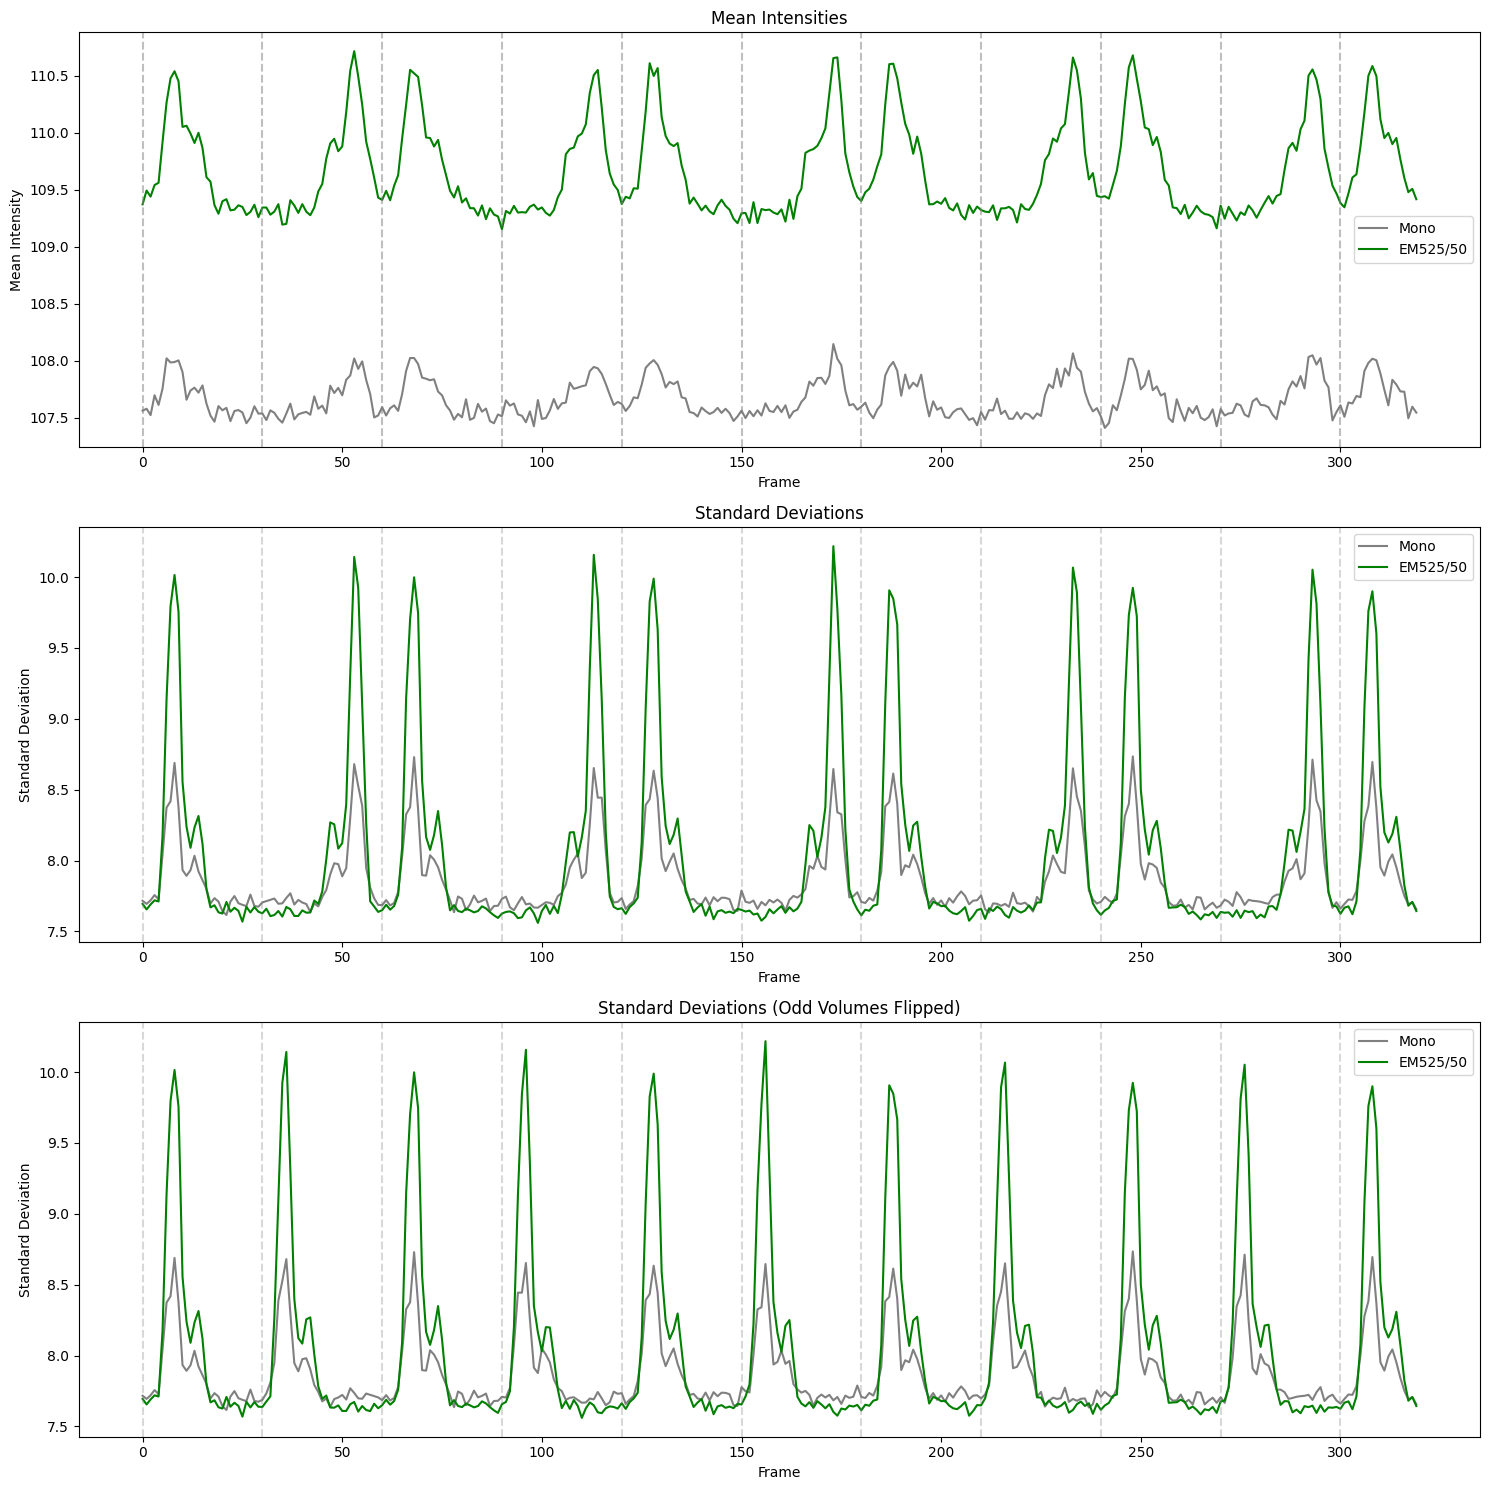

In [3]:
channel_names = ['Mono', 'EM525/50']
channel_colors = ['gray', 'green']

def inspect_raw_data(dask_array, start_frame=0, n_frames=200, fpv=32, y_min=Y_MIN, y_max=Y_MAX, x_min=X_MIN, x_max=X_MAX):
    """
    Inspect raw data before processing, using only a subset of frames.
    
    Args:
        dask_array: Input dask array (F, C, H, W)
        start_frame: Starting frame number
        n_frames: Number of frames to analyze
        fpv: Frames per volume
        y_min, y_max, x_min, x_max: Cropping boundaries
    """
    # Take only the subset we need
    subset = dask_array[start_frame:start_frame + n_frames]
    
    # Crop the array
    cropped = subset[:, :, y_min:y_max, x_min:x_max]
    
    # Calculate mean and std intensities (compute only what we need)
    print("Calculating intensity profiles...")
    mean_intensities = cropped.mean(axis=(2, 3)).compute()
    std_intensities = cropped.std(axis=(2, 3)).compute()
    
    # Create a copy of std_intensities for flipping odd volumes
    flipped_std = std_intensities.copy()
    n_volumes = n_frames // fpv
    
    # Flip odd-numbered volumes
    for vol in range(n_volumes):
        if vol % 2 == 1:  # odd-numbered volume
            start_idx = vol * fpv
            end_idx = start_idx + fpv
            flipped_std[start_idx:end_idx] = flipped_std[start_idx:end_idx][::-1]
    
    # Plot intensity profiles
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    
    # Plot mean intensities
    for c in range(cropped.shape[1]):
        ax1.plot(mean_intensities[:, c], label=f'{channel_names[c]}', color=channel_colors[c])
    
    # Add volume boundaries
    for i in range(0, n_frames, fpv):
        ax1.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_title('Mean Intensities')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Mean Intensity')
    ax1.legend()
    
    # Plot standard deviations
    for c in range(cropped.shape[1]):
        ax2.plot(std_intensities[:, c], label=f'{channel_names[c]}', color=channel_colors[c])
    
    # Add volume boundaries
    for i in range(0, n_frames, fpv):
        ax2.axvline(x=i, color='gray', linestyle='--', alpha=0.3)
    
    ax2.set_title('Standard Deviations')
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Standard Deviation')
    ax2.legend()
    
    # Plot standard deviations with odd volumes flipped
    for c in range(cropped.shape[1]):
        ax3.plot(flipped_std[:, c], label=f'{channel_names[c]}', color=channel_colors[c])
    
    # Add volume boundaries
    for i in range(0, n_frames, fpv):
        ax3.axvline(x=i, color='gray', linestyle='--', alpha=0.3)
    
    ax3.set_title('Standard Deviations (Odd Volumes Flipped)')
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Standard Deviation')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    return mean_intensities, std_intensities, flipped_std

fpv = 30
start_frame = 10
n_frames = 320

# Run initial inspection
_, _, _ = inspect_raw_data(
    dask_array,
    start_frame=start_frame,
    n_frames=n_frames,
    fpv=fpv,
)



# h5 conversion

In [4]:
from tqdm import tqdm
import numpy as np
import h5py

In [12]:
def flip_and_reshape_h5(dask_array, fpv=30, offset_frames=10, N_neurons=10, skip_cropping = False, noflip = False):
    """
    Flip alternate volumes in a dask array, reshape it, and save it as an HDF5 file.

    Args:
        dask_array: Input dask array with shape (F, C, H, W).
        output_path: Path to the output HDF5 file.
        fpv: Frames per volume.
        offset_frames: Number of frames to skip at the start to align with volume boundaries.
        N_neurons: Number of neurons for point data initialization.
    """
    total_frames = dask_array.shape[0]

    # Calculate start frame after offset
    start_frame = offset_frames

    # Calculate how many complete volumes we can have
    remaining_frames = total_frames - start_frame
    n_complete_volumes = remaining_frames // fpv
    end_frame = start_frame + (n_complete_volumes * fpv)

    # Create indices only for the frames we'll keep
    working_frames = end_frame - start_frame
    indices = np.arange(start_frame, end_frame)

    if not noflip:
        print("flipping")
    # Flip indices for odd-numbered volumes
        for vol in range(n_complete_volumes):
            if vol % 2 == 1:  # odd-numbered volume
                vol_start = start_frame + (vol * fpv)
                vol_end = vol_start + fpv
                indices[vol_start - start_frame:vol_end - start_frame] = \
                    indices[vol_start - start_frame:vol_end - start_frame][::-1]

    # Apply indices to dask array
    flipped_array = dask_array[indices]

    flipped_cropped_array = flipped_array[:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]

    # Reshape the array to (num_volumes, fpv, C, H, W)
    num_volumes = len(indices) // fpv
    reshaped_array = flipped_cropped_array.reshape(num_volumes, fpv, *flipped_cropped_array.shape[1:])

    # Transpose to (C, W, H, D) per frame
    transposed_array = reshaped_array.transpose(0, 2, 4, 3, 1)  # (num_volumes, C, W, H, fpv)
    return transposed_array
    # # Extract dimensions
    # C, W, H, D = transposed_array.shape[1:]
    # T = num_volumes

    # #Write to HDF5
    # with h5py.File(output_path, 'w') as f:
    #     for volume_idx in tqdm(range(transposed_array.shape[0]),desc="Writing volumes"):
    #         group = f.create_group(str(volume_idx))
    #         frame_data = transposed_array[volume_idx]
    #         group.create_dataset('frame', data=frame_data.astype(np.uint16), compression='gzip')

    #     # Initialize point data
    #     point_data = f.create_dataset("pointdat", (T, N_neurons + 1, 3), dtype="f4")
    #     point_data[...] = (np.random.random((T, N_neurons + 1, 3)) * np.array([W, H, D])[None, None, :]).astype(np.float32)
    #     point_data[:, 0] = np.nan

    #     # Add metadata attributes
    #     f.attrs["name"] = "testing-again"
    #     f.attrs["C"] = C
    #     f.attrs["W"] = W
    #     f.attrs["H"] = H
    #     f.attrs["D"] = D
    #     f.attrs["T"] = T
    #     f.attrs["N_neurons"] = N_neurons

# Example usage
# Assuming dask_array is already defined
#output_path = "./20250115-cropped-test.h5"
#unflipped_reshaped_array = flip_and_reshape_h5(dask_array, fpv=30, offset_frames=9, N_neurons=84, skip_cropping = True, noflip = True) #copying file I'm basing off
flipped_reshaped_array = flip_and_reshape_h5(dask_array, fpv=32, offset_frames=9, N_neurons=84, skip_cropping = True, noflip = False) #copying file I'm basing off


flipping


In [8]:
flipped_reshaped_array[0,:,]

dask.array<getitem, shape=(2, 350, 300, 30), dtype=uint16, chunksize=(2, 350, 300, 1), chunktype=numpy.ndarray>

In [10]:
N_neurons = 84

In [16]:
import dask.array as da
import numpy as np
import h5py
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

# Parameters
THRESHOLD_PERCENTILE = 99
GAMMA = None  # Gamma correction factor
# X_MIN, X_MAX = 450, 800  # Define cropping range
# Y_MIN, Y_MAX = 150, 450
SIGMA1 = 0.5  # Small sigma for DoG
SIGMA2 = 4.0  # Large sigma for DoG

# Difference of Gaussians filter
def dog_filter_2d(im, sigma1=0.5, sigma2=4.0):
    """Apply a difference of Gaussians filter."""
    im1 = gaussian_filter(im.astype(np.float32), sigma1)
    im2 = gaussian_filter(im.astype(np.float32), sigma2)
    return im1 - im2

# Sparsify a single Z-slice
from scipy.ndimage import median_filter

def sparsify_slice(slice_data, threshold_percentile, gamma=None):
    # Calculate the threshold value
    threshold_value = np.percentile(slice_data, threshold_percentile)
    
    # Apply threshold
    slice_sparse = np.where(slice_data >= threshold_value, slice_data, 0)
    
    # Apply median filtering to reduce salt-and-pepper noise
    slice_sparse = median_filter(slice_sparse, size=3)  # Adjust `size` as needed for your dataset
    
    # Apply gamma correction if specified
    if gamma is not None and slice_sparse.max() > 0:
        slice_sparse = (slice_sparse / slice_sparse.max()) ** gamma * slice_sparse.max()
    
    return slice_sparse

# Process Dask array in chunks
output_path = "./20250115-test-all-dog-less-sparsified-median-flipped-frames.h5"
with h5py.File(output_path, 'w') as f:
    for volume_idx in tqdm(range(flipped_reshaped_array.shape[0])):
        
        # Compute thmnme current frame lazily
        frame_data = flipped_reshaped_array[volume_idx, :, :].compute()
        # Apply DoG and sparsify each Z-slice for both channels
        sparsified_data = np.zeros_like(frame_data, dtype=np.uint8)
        for channel_idx in range(frame_data.shape[0]):  # Iterate over channels
            for z_idx in range(frame_data.shape[-1]):  # Iterate over Z-slices
                dog_filtered = dog_filter_2d(frame_data[channel_idx, :, :, z_idx], sigma1=SIGMA1, sigma2=SIGMA2)
                sparsified = sparsify_slice(dog_filtered, THRESHOLD_PERCENTILE, gamma=GAMMA)
                
                # Scale to uint8 range (0-255)
                if sparsified.max() > 0:
                    sparsified = (sparsified / sparsified.max() * 255).astype(np.uint8)
                
                sparsified_data[channel_idx, :, :, z_idx] = sparsified
        
        # Write sparsified data to HDF5
        group = f.create_group(str(volume_idx))
        group.create_dataset('frame', data=sparsified_data, dtype='u1', compression='gzip')

    # Initialize point data
    point_data = f.create_dataset("pointdat", (flipped_reshaped_array.shape[0], N_neurons + 1, 3), dtype="f4")
    point_data[...] = np.full((5, N_neurons + 1, 3), np.nan, dtype=np.float32)

    # Add metadata attributes
    f.attrs["name"] = "testing-flipped-dog-sparsified"
    f.attrs["C"] = flipped_reshaped_array.shape[1]
    f.attrs["W"] = X_MAX - X_MIN
    f.attrs["H"] = Y_MAX - Y_MIN
    f.attrs["D"] = flipped_reshaped_array.shape[-1]
    f.attrs["T"] = point_data.shape[0]
    f.attrs["N_neurons"] = N_neurons


100%|████████████████████████████████████████████████████████████████████| 624/624 [08:03<00:00,  1.29it/s]


TypeError: Can't broadcast (5, 85, 3) -> (624, 85, 3)

In [ ]:
import dask.array as da
import numpy as np
import h5py
from tqdm import tqdm

# Parameters
THRESHOLD_PERCENTILE = 99
GAMMA = None  # Gamma correction factor
X_MIN, X_MAX = 450, 800  # Define cropping range
Y_MIN, Y_MAX = 150, 450


# Sparsify a single Z-slice
def sparsify_slice(slice_data, threshold_percentile, gamma=None):
    # Calculate the threshold value
    threshold_value = np.percentile(slice_data, threshold_percentile)
    
    # Apply threshold
    slice_sparse = np.where(slice_data >= threshold_value, slice_data, 0)
    
    # Apply gamma correction if specified
    if gamma is not None and slice_sparse.max() > 0:
        slice_sparse = (slice_sparse / slice_sparse.max()) ** gamma * slice_sparse.max()
    
    return slice_sparse

# Process Dask array in chunks
output_path = "./20250115-test-5-sparsified-frames.h5"
with h5py.File(output_path, 'w') as f:
    for volume_idx in tqdm(range(reshaped_array.shape[0])):
        if volume_idx > 5:
            break
        
        # Compute the current frame lazily
        frame_data = reshaped_array[volume_idx, :, X_MIN:X_MAX, Y_MIN:Y_MAX, :].compute()
        
        # Sparsify each Z-slice for both channels
        sparsified_data = np.zeros_like(frame_data)
        for channel_idx in range(frame_data.shape[0]):  # Iterate over channels
            for z_idx in range(frame_data.shape[-1]):  # Iterate over Z-slices
                sparsified_data[channel_idx, :, :, z_idx] = sparsify_slice(
                    frame_data[channel_idx, :, :, z_idx],
                    THRESHOLD_PERCENTILE,
                    gamma=GAMMA
                )
        
        # Write sparsified data to HDF5
        group = f.create_group(str(volume_idx))
        group.create_dataset('frame', data=sparsified_data.astype(np.uint16), dtype='i2', compression='gzip')

    # Initialize point data
    point_data = f.create_dataset("pointdat", (5, N_neurons + 1, 3), dtype="f4")
    point_data[...] = np.full((5, N_neurons + 1, 3), np.nan, dtype=np.float32)

    # Add metadata attributes#unflipped_reshaped_array = flip_and_reshape_h5(dask_array, fpv=30, offset_frames=9, N_neurons=84, skip_cropping = True, noflip = True) #copying file I'm basing off

    f.attrs["name"] = "testing-sparsified"
    f.attrs["C"] = reshaped_array.shape[1]
    f.attrs["W"] = X_MAX - X_MIN
    f.attrs["H"] = Y_MAX - Y_MIN
    f.attrs["D"] = reshaped_array.shape[-1]
    f.attrs["T"] = point_data.shape[0]
    f.attrs["N_neurons"] = N_neurons

  1%|▋                                                                     | 6/666 [00:01<03:23,  3.24it/s]


In [6]:
N_neurons = 84

In [7]:
reshaped_array.shape[0]

666

In [7]:
# Extract dimensions
T, C, W, H, D = reshaped_array.shape

output_path = "./20250115-test-5-uncropped-frames.h5"
#Write to HDF5
with h5py.File(output_path, 'w') as f:
    for volume_idx in tqdm(range(0, reshaped_array.shape[0])):
        if volume_idx > 5: 
            break
        group = f.create_group(str(volume_idx))
        frame_data = reshaped_array[volume_idx]
        group.create_dataset('frame', data=frame_data.astype(np.uint16), dtype = 'i2', compression='gzip')

    # Initialize point data
    point_data = f.create_dataset("pointdat", (5, N_neurons + 1, 3), dtype="f4")
    point_data[...] = np.full((5, N_neurons + 1, 3), np.nan, dtype=np.float32)

    # Add metadata attributes
    f.attrs["name"] = "testing-again"
    f.attrs["C"] = C
    f.attrs["W"] = W
    f.attrs["H"] = H
    f.attrs["D"] = D
    f.attrs["T"] = point_data.shape[0]
    f.attrs["N_neurons"] = N_neurons


  1%|▋                                                                     | 6/666 [00:10<19:00,  1.73s/it]


In [8]:
# Extract dimensions
T, C, W, H, D = reshaped_array.shape

output_path = "./20250115-test-5-cropped-frames.h5"
#Write to HDF5
with h5py.File(output_path, 'w') as f:
    for volume_idx in tqdm(range(0, reshaped_array.shape[0])):
        if volume_idx > 5: 
            break
        group = f.create_group(str(volume_idx))
        frame_data = reshaped_array[volume_idx, :, X_MIN:X_MAX, Y_MIN:Y_MAX, :]
        group.create_dataset('frame', data=frame_data.astype(np.uint16), dtype = 'i2', compression='gzip')

    # Initialize point data
    point_data = f.create_dataset("pointdat", (5, N_neurons + 1, 3), dtype="f4")
    point_data[...] = np.full((5, N_neurons + 1, 3), np.nan, dtype=np.float32)

    # Add metadata attributes
    f.attrs["name"] = "testing-again-again"
    f.attrs["C"] = C
    f.attrs["W"] = W
    f.attrs["H"] = H
    f.attrs["D"] = D
    f.attrs["T"] = point_data.shape[0]
    f.attrs["N_neurons"] = N_neurons


  1%|▋                                                                     | 6/666 [00:06<11:49,  1.07s/it]


  1%|▋                                                                     | 6/666 [00:01<03:18,  3.33it/s]


In [14]:
import numpy as np
import h5py
from tqdm import tqdm

# Parameters
THRESHOLD_PERCENTILE = 95

# Sparsify a single Z-slice
def sparsify_slice(slice_data, threshold_percentile, gamma=None):
    # Calculate the threshold value
    threshold_value = np.percentile(slice_data, threshold_percentile)
    
    # Apply threshold
    slice_sparse = np.where(slice_data >= threshold_value, slice_data, 0)
    
    # Apply gamma correction if specified
    if gamma is not None and slice_sparse.max() > 0:
        slice_sparse = (slice_sparse / slice_sparse.max()) ** gamma * slice_sparse.max()
    
    return slice_sparse

# Process HDF5 file with sparsification
output_path = "./20250115-test-5-sparsified-frames.h5"
with h5py.File(output_path, 'w') as f:
    for volume_idx in tqdm(range(reshaped_array.shape[0])):
        if volume_idx > 5:
            break
        
        # Extract and crop frame data (2 x X x Y x Z)
        frame_data = reshaped_array[volume_idx, :, X_MIN:X_MAX, Y_MIN:Y_MAX, :]
        
        # Sparsify each Z-slice for both channels
        sparsified_data = np.zeros_like(frame_data)
        for channel_idx in range(frame_data.shape[0]):  # Iterate over channels
            for z_idx in range(frame_data.shape[-1]):  # Iterate over Z-slices
                sparsified_data[channel_idx, :, :, z_idx] = sparsify_slice(
                    frame_data[channel_idx, :, :, z_idx], 
                    THRESHOLD_PERCENTILE, 
                    gamma=GAMMA
                )
        
        # Write sparsified data to HDF5
        group = f.create_group(str(volume_idx))
        group.create_dataset('frame', data=sparsified_data.astype(np.uint16), dtype='i2', compression='gzip')

    # Initialize point data
    point_data = f.create_dataset("pointdat", (5, N_neurons + 1, 3), dtype="f4")
    point_data[...] = np.full((5, N_neurons + 1, 3), np.nan, dtype=np.float32)

    # Add metadata attributes
    f.attrs["name"] = "testing-sparsified"
    f.attrs["C"] = 2
    f.attrs["W"] = X_MAX - X_MIN
    f.attrs["H"] = Y_MAX - Y_MIN
    f.attrs["D"] = frame_data.shape[-1]
    f.attrs["T"] = point_data.shape[0]
    f.attrs["N_neurons"] = N_neurons

  0%|                                                                              | 0/666 [00:00<?, ?it/s]


AttributeError: 'generator' object has no attribute 'ndim'

In [15]:
print(type(reshaped_array))
print(reshaped_array.shape)

<class 'resource_backed_dask_array.ResourceBackedDaskArray'>
(666, 2, 1024, 512, 30)


In [10]:
import h5py
import numpy as np

# Path to the HDF5 file
input_path = "./unlabeled_worm_head_example.h5" # 5"

# Read and print the contents of the frame datasets
with h5py.File(input_path, 'r') as f:
    # Iterate through the groups (volume indices)
    for volume_idx in f.keys():
        if volume_idx.isdigit():  # Ensure it is a valid group index
            frame_data = f[volume_idx]['frame'][:]
            print(f"Volume Index: {volume_idx}")
            print(f"Frame Data (shape {frame_data.shape}):")
            print(frame_data)
            print("-" * 50)

    # Print metadata attributes
    print("Metadata Attributes:")
    for key, value in f.attrs.items():
        print(f"{key}: {value}")

Volume Index: 0
Frame Data (shape (2, 256, 160, 16)):
[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0

In [22]:
h5_file_path = '/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5'
with h5py.File(h5_file_path, 'r') as f:
    # List all groups
    non_frame_groups = [k for  k in list(f.keys()) if not k.isdigit()]


    for name in non_frame_groups:
        obj = f[name]
        if isinstance(obj, h5py.Group):
            print(f"Group: {name} (Contains {len(obj)} members)")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} (Shape: {obj.shape}, Type: {obj.dtype})")file_path = '/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5'

def inspect_dataset(file_path, dataset_name):
    with h5py.File(file_path, 'r') as f:
        if dataset_name in f:
            dataset = f[dataset_name]
            print(f"\nInspecting Dataset: {dataset_name}")
            print(f"Shape: {dataset.shape}")
            print(f"Dtype: {dataset.dtype}")
            print(f"Attributes: {dict(dataset.attrs)}\n")
            
            # Display a small subset of the data
            print(f"First 5 entries of '{dataset_name}':")
            # Depending on the shape, slice appropriately
            if dataset.ndim == 3:
                # For 'pointdat' with shape (3002, 85, 3)
                print(dataset[:5, :5, :])
            elif dataset.ndim == 2:
                # For 'neuron_presence' with shape (3002, 85)
                print(dataset[:5, :5])
            else:
                print(dataset[:5])
            
            # Compute summary statistics
            data = dataset[:]
            print("\nSummary Statistics:")
            print(f"Min: {np.nanmin(data)}")
            print(f"Max: {np.nanmax(data)}")
            print(f"Mean: {np.nanmean(data)}")
            print(f"Std Dev: {np.nanstd(data)}")
        else:
            print(f"Dataset '{dataset_name}' not found in the HDF5 file.")

Dataset: ci_int (Shape: (84, 3002, 2), Type: float32)
Group: cluster_params (Contains 0 members)
Dataset: neuron_presence (Shape: (3002, 85), Type: bool)
Dataset: pointdat (Shape: (3002, 85, 3), Type: float32)
Dataset: points (Shape: (3002, 85, 3), Type: float32)
Group: seg_params (Contains 0 members)


In [23]:
file_path = '/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5'

def inspect_dataset(file_path, dataset_name):
    with h5py.File(file_path, 'r') as f:
        if dataset_name in f:
            dataset = f[dataset_name]
            print(f"\nInspecting Dataset: {dataset_name}")
            print(f"Shape: {dataset.shape}")
            print(f"Dtype: {dataset.dtype}")
            print(f"Attributes: {dict(dataset.attrs)}\n")
            
            # Display a small subset of the data
            print(f"First 5 entries of '{dataset_name}':")
            # Depending on the shape, slice appropriately
            if dataset.ndim == 3:
                # For 'pointdat' with shape (3002, 85, 3)
                print(dataset[:5, :5, :])
            elif dataset.ndim == 2:
                # For 'neuron_presence' with shape (3002, 85)
                print(dataset[:5, :5])
            else:
                print(dataset[:5])
            
            # Compute summary statistics
            data = dataset[:]
            print("\nSummary Statistics:")
            print(f"Min: {np.nanmin(data)}")
            print(f"Max: {np.nanmax(data)}")
            print(f"Mean: {np.nanmean(data)}")
            print(f"Std Dev: {np.nanstd(data)}")
        else:
            print(f"Dataset '{dataset_name}' not found in the HDF5 file.")

In [32]:
with h5py.File(file_path, 'r') as f:
    print(f['0']['frame'])

<HDF5 dataset "frame": shape (2, 256, 160, 16), type "|u1">


In [28]:
inspect_dataset(file_path, '1')


Inspecting Dataset: 1


AttributeError: 'Group' object has no attribute 'shape'

In [1]:
import h5py

# Open the HDF5 file
h5_file_path = '/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5'
with h5py.F# Load the ND2 file
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
data = nd2.imread(file_path)ile(file_path, 'r') as f:
    # Check if the 'pointdat' dataset exists
    if 'pointdat' in f:
        # Access the 'pointdat' dataset
        pointdat = f['pointdat']
        
        # Print basic information about 'pointdat'
        print("Dataset: 'pointdat'")
        print(f"Shape: {pointdat.shape}")
        print(f"Dtype: {pointdat.dtype}")
        
        # Optionally, preview a subset of data
        print("\nPreview of data (first 5 entries):")
        print(pointdat[:5])
    else:
        print("'pointdat' dataset not found in the file.")

    # List all attributes in the file (optional)
    print("\nFile attributes:")
    for key in f.attrs.keys():
        print(f"{key}: {f.attrs[key]}")

    # List all datasets/groups at the root level
    print("\nMain groups/datasets:")
    for key in f.keys():
        print(key)


Dataset: 'pointdat'
Shape: (3002, 85, 3)
Dtype: float32

Preview of data (first 5 entries):
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]

File attributes:
C: 2
D: 16
H: 160
N_neurons: 84
N_points: 84
T: 3002
W: 256
dset_path_from_GUI: /nese/mit/group/boydenlab/Konstantinos/targettrack_data/unlabeled_worm_head_example.h5
name: 184
pixel_scale: [1 1 4]
pointdat: True

Main groups/datasets:
0
1
10
100
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
101
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
102
1020
1021
1022


In [11]:
import h5py

# Open the file
f = h5py.File('/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5', 'r')

# Inspect the structure of datasets
for key in f.keys():
    print(f"Dataset: {key}")
    data = f[key]
    print(f" - Shape: {data.shape}")
    print(f" - Dtype: {data.dtype}")
    print(f" - Attributes: {list(data.attrs.keys())}")

f.close()


Dataset: 0


AttributeError: 'Group' object has no attribute 'shape'